In [1]:
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split

import cv2
import numpy as np
import matplotlib.pyplot as plt

import os

from tqdm import tqdm

In [2]:
def genOneHotkey(hotkey_position, num_class):
  oneHotkey = []
  
  for i in range(num_class):
    if i ==  hotkey_position:
      oneHotkey.append(1)
    else:
      oneHotkey.append(0)

  return oneHotkey

In [3]:
def imagesToDatas(image_path_list, image_width, index_of_classname,):
  dataImages = []
  oneHotkeys = []

  num_class = len(image_path_list)

  classnameToHotkeyPosition = dict()
  hotkeyCount = 0

  for path in image_path_list:

      classname = path.split('/')[index_of_classname]

      if classname not in classnameToHotkeyPosition.keys():
        classnameToHotkeyPosition[classname] = hotkeyCount
        hotkeyCount+=1

      for item in tqdm(os.listdir(path)):
          file_path = os.path.join(path, item)

          if os.path.isfile(file_path):
            dataImage = cv2.imread(file_path,cv2.cv2.COLOR_BGR2RGB)

            # Convert Gray sys. image to RGB sys.
            if len(dataImage.shape) == 2:
                dataImage = cv2.cvtColor(dataImage, cv2.COLOR_GRAY2RGB)
       
            dataImage = cv2.resize(dataImage,(image_width,image_width))

            dataImages.append(dataImage)
            oneHotkeys.append(genOneHotkey(classnameToHotkeyPosition[classname],num_class))

  return dataImages, oneHotkeys, num_class

In [4]:
path_dataset = os.path.join(os.getcwd(),'drive','MyDrive','Colab Notebooks','dataset')

dataset_image_path_list = list(filter(os.path.isdir, list(map(path_dataset.__add__, map('/'.__add__, os.listdir(path_dataset))))))
dataset_image_path_list.sort()

print('dataset_image_path_list : {} '.format(dataset_image_path_list))

dataset_image_path_list : ['/content/drive/MyDrive/Colab Notebooks/dataset/baseball', '/content/drive/MyDrive/Colab Notebooks/dataset/basketball', '/content/drive/MyDrive/Colab Notebooks/dataset/beachballs', '/content/drive/MyDrive/Colab Notebooks/dataset/billiard ball', '/content/drive/MyDrive/Colab Notebooks/dataset/bowling ball', '/content/drive/MyDrive/Colab Notebooks/dataset/brass', '/content/drive/MyDrive/Colab Notebooks/dataset/buckeyballs', '/content/drive/MyDrive/Colab Notebooks/dataset/cannon ball', '/content/drive/MyDrive/Colab Notebooks/dataset/cricket ball', '/content/drive/MyDrive/Colab Notebooks/dataset/eyeballs', '/content/drive/MyDrive/Colab Notebooks/dataset/football', '/content/drive/MyDrive/Colab Notebooks/dataset/golf ball', '/content/drive/MyDrive/Colab Notebooks/dataset/marble', '/content/drive/MyDrive/Colab Notebooks/dataset/meat ball', '/content/drive/MyDrive/Colab Notebooks/dataset/medicine ball', '/content/drive/MyDrive/Colab Notebooks/dataset/paint balls', '

In [5]:
image_width = 128

# **Data Collection**



In [6]:
x, y, num_class = imagesToDatas(dataset_image_path_list, image_width, 6)

print('\n')
print('number of class : {}'.format(num_class))
print('y (oneHotkey) : {}'.format(y))

100%|██████████| 74/74 [00:32<00:00,  2.28it/s]



number of class : 24
y (oneHotkey) : [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# **Data Preprocessing**



In [7]:
x = np.array(x)
y = np.array(y)

# Preprocessing data for Xception model
x = tf.keras.applications.xception.preprocess_input(x)

print('x shape : {}'.format(x.shape))
print('y shape : {}'.format(y.shape))

x shape : (2980, 128, 128, 3)
y shape : (2980, 24)


# **Data Spliting**

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=32)

print('x_train shape : {}'.format(x_train.shape))
print('y_train shape : {}'.format(y_train.shape))
print('x_test shape : {}'.format(x_test.shape))
print('y_test shape : {}'.format(y_test.shape))

x_train shape : (2384, 128, 128, 3)
y_train shape : (2384, 24)
x_test shape : (596, 128, 128, 3)
y_test shape : (596, 24)


# **Create Neural Network**

In [9]:
# Create base model from Xception
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(image_width,image_width,3),
    pooling='avg',
)

# Freeze base model
base_model.trainable = False

# Create new model by merging base model with some layers
model = keras.Sequential([
        base_model,

        keras.layers.Flatten(),
        keras.layers.Dense(num_class, activation='softmax')   # use softmax for one hot  / use sigmoid for [0/1]
    ])

model.build((None,image_width,image_width,3))
model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 2048)              20861480  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 24)                49176     
Total params: 20,910,656
Trainable params: 49,176
Non-trainable params: 20,861,480
_________________________________________________________________


# **Choose Optimizer**

In [10]:
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics= ['accuracy'])

# **Model Training**



In [11]:
batch_size = 32
epochs = 15

history = model.fit(x_train, y_train ,batch_size=batch_size, epochs=epochs ,validation_data=(x_test, y_test))

Epoch 1/15
75/75 [==============================] - 56s 156ms/step - loss: 1.8103 - accuracy: 0.5184 - val_loss: 0.5448 - val_accuracy: 0.8440
Epoch 2/15
75/75 [==============================] - 9s 124ms/step - loss: 0.3797 - accuracy: 0.9089 - val_loss: 0.4638 - val_accuracy: 0.8658
Epoch 3/15
75/75 [==============================] - 9s 125ms/step - loss: 0.2289 - accuracy: 0.9496 - val_loss: 0.3780 - val_accuracy: 0.8809
Epoch 4/15
75/75 [==============================] - 9s 125ms/step - loss: 0.1599 - accuracy: 0.9676 - val_loss: 0.3586 - val_accuracy: 0.8909
Epoch 5/15
75/75 [==============================] - 9s 125ms/step - loss: 0.1141 - accuracy: 0.9798 - val_loss: 0.3586 - val_accuracy: 0.8943
Epoch 6/15
75/75 [==============================] - 9s 125ms/step - loss: 0.0897 - accuracy: 0.9893 - val_loss: 0.3572 - val_accuracy: 0.8943
Epoch 7/15
75/75 [==============================] - 9s 125ms/step - loss: 0.0770 - accuracy: 0.9872 - val_loss: 0.3665 - val_accuracy: 0.8842
Epoch

# **Model Evaluation**


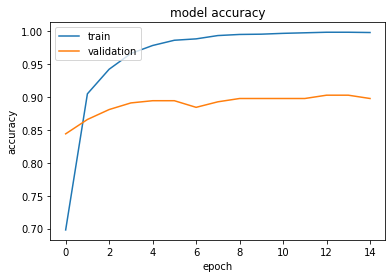

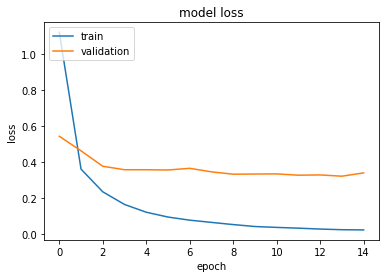

In [12]:
#Accuracy Graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#Loss Graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# **Model Saving**

In [13]:
model.save(os.path.join(os.getcwd(),'drive','MyDrive','Colab Notebooks','model'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/model/assets
